# Food Image Classification with Transfer Learning and Experiment Tracking

**This notebook demonstrates** the process of building an image classification model for a custom food dataset using transfer learning to adapt pretrained models for improved accuracy, along with experiment tracking to identify the most effective model architecture and hyperparameter configuration.

## Transfer Learning

### Imports

In [20]:
import sys
sys.path.insert(0, '..')

import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchinfo import summary
from scripts.data_setup import create_dataloaders
from scripts.engine import train, train_step, test_step
from scripts.utils import accuracy_fn, plot_loss_and_accuracy_curves, save_model
from pathlib import Path
from PIL import Image
import random
import zipfile
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm import tqdm

### Device agnostic code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Getting data

In [3]:
data_name = 'baklava_churros_cheesecake'
data_path = Path('../data/processed')
images_path = data_path / data_name
zip_path = Path(str(images_path) + '.zip')

if not images_path.is_dir():
    images_path.mkdir(parents=True, exist_ok=True)
    if zip_path.exists():
        with zipfile.ZipFile(zip_path, 'r') as zip:
            zip.extractall(images_path)
    else:
        print(f'{data_name} is wrong name or custom dataset was not created.\n'
              'Use custom dataset notebook to create dataset.')
        images_path.rmdir()

train_dir = images_path / 'train'
test_dir = images_path / 'test'

### Creating DataLoaders

In [4]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
transforms = weights.transforms()

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=transforms,
                                                                    batch_size=32)

In [19]:
len(train_dataloader)

71

### Setting up pretrained model

In [5]:
models_dir_path = Path('../models')
models_dir_path.mkdir(parents=True,
                      exist_ok=True)

os.environ['TORCH_HOME'] = str(models_dir_path)
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
def model_summary(model: torch.nn.Module) -> None:
    """Prints a detailed summary of a Pytorch model.
    
    Args:
        model: The Pytorch model to summarize.
    """
    print(summary(model=model,
                  input_size=(32, 3, 224, 224),
                  verbose=0,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'],
                  col_width=18,
                  row_settings=['var_names']
                  ))

In [7]:
model_summary(model)

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]  [32, 1000]         --                 True
├─Sequential (features)                                      [32, 3, 224, 224]  [32, 1280, 7, 7]   --                 True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]  [32, 32, 112, 112] --                 True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]  [32, 32, 112, 112] 864                True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64                 True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --                 True
│    │    └─M

In [9]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for param in model.features.parameters():
    param.requires_grad = False

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [10]:
model_summary(model)

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]  [32, 3]            --                 Partial
├─Sequential (features)                                      [32, 3, 224, 224]  [32, 1280, 7, 7]   --                 False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]  [32, 32, 112, 112] --                 False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]  [32, 32, 112, 112] (864)              False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)               False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --                 False
│    

### Training a model

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

model_results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                epochs=5,
                device=device)

 20%|██        | 1/5 [01:46<07:07, 106.96s/it]

Epoch: 1 | train_loss: 0.6759 | train_acc: 75.9507 | test_loss: 0.3938 | test_acc: 89.3229


 40%|████      | 2/5 [03:33<05:20, 106.82s/it]

Epoch: 2 | train_loss: 0.4232 | train_acc: 85.8275 | test_loss: 0.3168 | test_acc: 89.9740


 60%|██████    | 3/5 [05:21<03:34, 107.06s/it]

Epoch: 3 | train_loss: 0.3629 | train_acc: 88.5035 | test_loss: 0.2855 | test_acc: 90.4948


 80%|████████  | 4/5 [07:08<01:47, 107.05s/it]

Epoch: 4 | train_loss: 0.3308 | train_acc: 89.3486 | test_loss: 0.2633 | test_acc: 91.5365


100%|██████████| 5/5 [08:54<00:00, 106.92s/it]

Epoch: 5 | train_loss: 0.3087 | train_acc: 88.9437 | test_loss: 0.2485 | test_acc: 90.6250


### Plot loss and accuracy curves

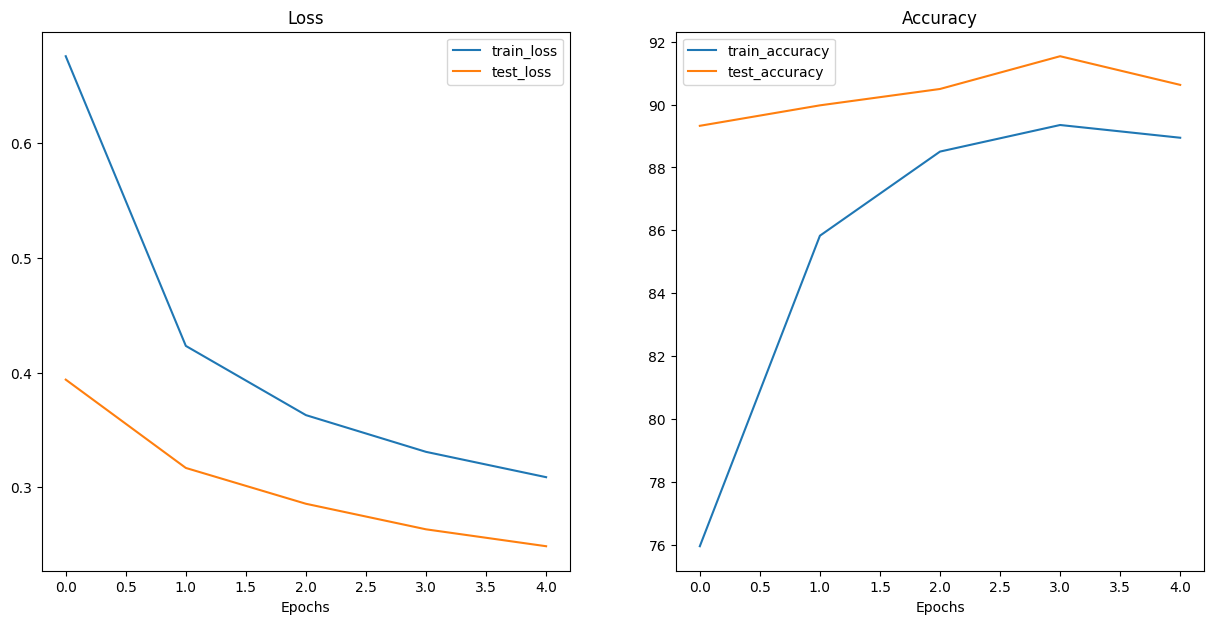

In [11]:
plot_loss_and_accuracy_curves(model_results)

### Make prediction on images from test set

In [54]:
def predict_and_plot_image(
        model: torch.nn.Module,
        images_path: str,
        class_names: list[str],
        transform: torchvision.transforms = transforms,
        device: torch.device = device
) -> None:
    """Predicts the class of an image and plots it with the predicted label.

    This function loads an image from the specified path, applies the given
    transformations, passes it through the model to obtain predictions, and
    displays the image with its predicted class.

    Args:
        model: The trained PyTorch model for prediction.
        images_path: Path to the image file to predict.
        class_names: List of class names corresponding to model outputs.
        transform: Transformations to apply to the image.
        device: Target device to run computations on (e.g., 'cpu' or 'cuda').
    """
    img = Image.open(images_path)

    model.to(device)
    model.eval()
    with torch.inference_mode():
        # model requires samples in [batch_size, color_channels, height, width]
        transformed_image = transform(img).unsqueeze(dim=0).to(device)
        image_pred = model(transformed_image)

        # Logits -> Proba -> Labels
        image_label = torch.argmax(torch.softmax(image_pred, dim=1), dim=1)

        plt.figure()
        plt.imshow(img)
        plt.title(f'Prediction: {class_names[image_label]}')
        plt.axis(False)

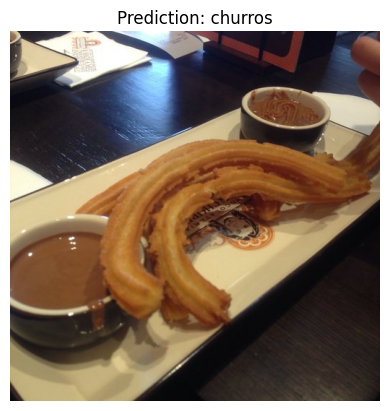

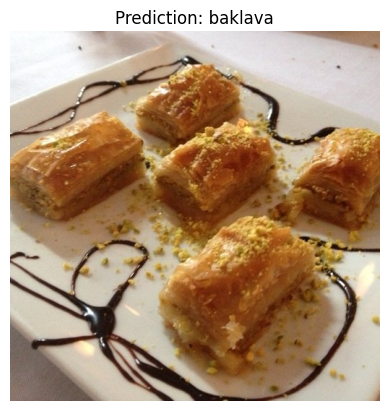

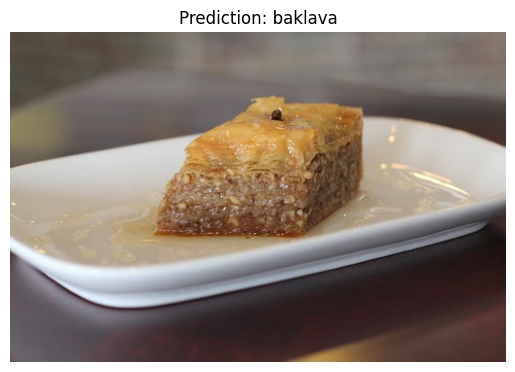

In [13]:
random.seed(42)
num_images = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_random_sample = random.sample(population=test_image_path_list,
                                              k=num_images)

for image_path in test_image_path_random_sample:
    predict_and_plot_image(model=model,
                           images_path=image_path,
                           class_names=class_names)

## Experiment Tracking

### Creating a log function

In [28]:
def create_writer(model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.SummaryWriter:
    """Creates a SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/model_name/extra.

    Args:
        model_name: Name of model.
        extra: Anything extra to add to the directory. Defaults to None.

    Returns:
        Instance of a writer saving to log_dir.
    """
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join("runs", timestamp, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

### Updating train function

In [29]:
def train(
        model: torch.nn.Module, 
        train_dataloader: torch.utils.data.DataLoader, 
        test_dataloader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        accuracy_fn: callable,
        epochs: int,
        device: torch.device,
        writer: torch.utils.tensorboard.writer.SummaryWriter
) -> dict[str, list[float]]:
    """Train and evaluate a PyTorch model over multiple epochs.

    Runs the training loop using `train_step` and evaluation loop using `test_step`
    for a specified number of epochs. Tracks and returns loss and accuracy metrics
    for both training and testing.

    Args:
        model: The neural network model to be trained and evaluated.
        train_dataloader: DataLoader providing the training dataset in batches.
        test_dataloader: DataLoader providing the test/validation dataset in batches.
        optimizer: Optimizer used to update model parameters based on gradients.
        loss_fn: Loss function used to compute the error between predictions and targets.
        accuracy_fn: Function to calculate accuracy. 
            Should accept `y_true` (labels) and `y_pred` (predicted labels).
        epochs: Number of epochs (full passes through the training dataset).
        device: Target device to run computations on (e.g., 'cpu' or 'cuda').
        writer: A SummaryWriter() instance to log model results to.

    Returns:
        A dictionary containing per-epoch metrics.
    """
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn,
                                        device=device)
        
        print(
            f'Epoch: {epoch+1} | '
            f'train_loss: {train_loss:.4f} | '
            f'train_acc: {train_acc:.4f} | '
            f'test_loss: {test_loss:.4f} | '
            f'test_acc: {test_acc:.4f}'
        )

        results['train_loss'].append(train_loss.item() if hasattr(train_loss, 'item') else train_loss)
        results['train_acc'].append(train_acc.item() if hasattr(train_acc, 'item') else train_acc)
        results['test_loss'].append(test_loss.item() if hasattr(test_loss, 'item') else test_loss)
        results['test_acc'].append(test_acc.item() if hasattr(test_acc, 'item') else test_acc)

        if writer:
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)
            writer.close()
        else:
            pass

    return results

### Setting up pretrained models

In [56]:
effnetv2_s_weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
effnetv2_s = torchvision.models.efficientnet_v2_s(weights=effnetv2_s_weights).to(device)

print(f'Number of in_features to final layer of EfficientNetB2: {len(effnetv2_s.classifier.state_dict()['1.weight'][0])}')


Number of in_features to final layer of EfficientNetB2: 1280


In [42]:
model_summary(effnetv2_s)

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]  [32, 1000]         --                 True
├─Sequential (features)                                      [32, 3, 224, 224]  [32, 1280, 7, 7]   --                 True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]  [32, 24, 112, 112] --                 True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]  [32, 24, 112, 112] 648                True
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112] [32, 24, 112, 112] 48                 True
│    │    └─SiLU (2)                                         [32, 24, 112, 112] [32, 24, 112, 112] --                 --
│    └─Sequential (1)                                        [32, 24, 112, 112] [32, 24, 112, 112] --                 True
│    │    └─F

In [47]:
def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(in_features=1280, out_features=len(class_names))
    ).to(device)

    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

def create_effnetv2_s():
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
    model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(in_features=1280, out_features=len(class_names))
    ).to(device)

    model.name = "effnetv2_s"
    print(f"[INFO] Created new {model.name} model.")
    return model

### Experiments

In [48]:
num_epochs = [5]
models = ["effnetb0", "effnetb1"]

In [49]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_experiments = 0

for epochs in num_epochs: 

    for model_name in models:

        num_experiments += 1
        print(f"[INFO] Experiment number: {num_experiments}")
        print(f"[INFO] Number of epochs: {epochs}") 
        print(f"[INFO] Model: {model_name}")

        if model_name == "effnetb0":
            model = create_effnetb0()
        else:
            model = create_effnetv2_s()
            
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

        train(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              epochs=epochs,
              device=device,
              writer=create_writer(model_name=model_name,
                                   extra=f'{epochs}_epochs'))
            
        save_filepath = f"{model_name}_{epochs}_epochs.pth"
        save_model(model=model,
                   model_name=save_filepath,
                   target_dir='../models')
        print("-"*20 + "\n")

[INFO] Experiment number: 1
[INFO] Number of epochs: 5
[INFO] Model: effnetb0
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2025-10-06\effnetb0\5_epochs...


 20%|██        | 1/5 [01:57<07:49, 117.26s/it]

Epoch: 1 | train_loss: 0.6856 | train_acc: 76.8310 | test_loss: 0.4020 | test_acc: 89.3229


 40%|████      | 2/5 [04:12<06:23, 127.70s/it]

Epoch: 2 | train_loss: 0.4397 | train_acc: 85.4930 | test_loss: 0.3359 | test_acc: 89.7135


 60%|██████    | 3/5 [06:28<04:22, 131.46s/it]

Epoch: 3 | train_loss: 0.3681 | train_acc: 87.7553 | test_loss: 0.2891 | test_acc: 91.1458


 80%|████████  | 4/5 [08:43<02:12, 132.83s/it]

Epoch: 4 | train_loss: 0.3308 | train_acc: 88.7676 | test_loss: 0.2697 | test_acc: 91.0156


100%|██████████| 5/5 [10:59<00:00, 131.92s/it]

Epoch: 5 | train_loss: 0.3155 | train_acc: 88.6708 | test_loss: 0.2585 | test_acc: 91.9271
Saving model to: ..\models\effnetb0_5_epochs.pth.
--------------------

[INFO] Experiment number: 2
[INFO] Number of epochs: 5
[INFO] Model: effnetb1


[INFO] Created new effnetv2_s model.
[INFO] Created SummaryWriter, saving to: runs\2025-10-06\effnetb1\5_epochs...


 20%|██        | 1/5 [04:34<18:18, 274.52s/it]

Epoch: 1 | train_loss: 0.7134 | train_acc: 74.1373 | test_loss: 0.4716 | test_acc: 86.1607


 40%|████      | 2/5 [08:29<12:33, 251.26s/it]

Epoch: 2 | train_loss: 0.4776 | train_acc: 83.7588 | test_loss: 0.3886 | test_acc: 87.6302


 60%|██████    | 3/5 [12:32<08:14, 247.36s/it]

Epoch: 3 | train_loss: 0.4086 | train_acc: 85.5546 | test_loss: 0.3536 | test_acc: 88.6719


 80%|████████  | 4/5 [16:16<03:58, 238.16s/it]

Epoch: 4 | train_loss: 0.3822 | train_acc: 86.0739 | test_loss: 0.3330 | test_acc: 88.5417


100%|██████████| 5/5 [20:28<00:00, 245.73s/it]

Epoch: 5 | train_loss: 0.3639 | train_acc: 86.5141 | test_loss: 0.3254 | test_acc: 88.6719
Saving model to: ..\models\effnetb1_5_epochs.pth.
--------------------



In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

### Loading the best model and making predictions with it

In [52]:
best_model_path = "../models/effnetb0_5_epochs.pth"

best_model = create_effnetb0()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0 model.


<All keys matched successfully>

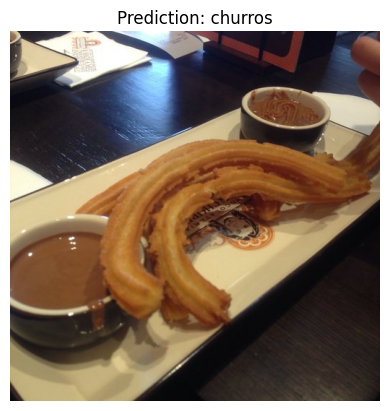

In [55]:
random.seed(42)
num_images = 1
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_random_sample = random.sample(population=test_image_path_list,
                                              k=num_images)

for image_path in test_image_path_random_sample:
    predict_and_plot_image(model=best_model,
                           images_path=image_path,
                           class_names=class_names)